In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import sampler
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset
import torchvision.transforms.transforms as T
from torchvision.datasets import ImageFolder
from PIL import Image
from tqdm import tqdm
import copy

TRAIN_IMG_PATH="G:/Dataset/CASIA-HWDB/HWDB-10/train"                  
TEST_IMG_PATH="G:/Dataset/CASIA-HWDB/HWDB-10/test"

USE_GPU = True

TRAIN_SET_NUM = 1800
VAL_SET_NUM = 600
TEST_SET_NUM = 600

BATCH_SIZE = 4
INPUT_SIZE = 3*32*32
HIDDEN_1_SIZE = 512
OUTPUT_SIZE = 10
EPOCH_NUM = 15

#数据增强
# transform_aug = T.Compose([
#     T.ColorJitter(brightness=0.5),
#     #T.RandomRotation(20, resample=Image.BICUBIC, expand=False, center=(16, 16)),
#     T.ToTensor(),
#     T.Normalize((1.5774859,1.742162,1.9566413), (0.9210081,0.94156635,0.9373817))
# ])

transform_normal = T.Compose([
    T.ToTensor(),
    T.Normalize((0.8959238,0.8959238,0.8959238), (0.18494467, 0.18494467, 0.18494467))
])

class MyDataset(Dataset):
    def __init__(self, filenames, labels, transform):
        self.filenames = filenames
        self.labels = labels
        self.transform = transform
 
    def __len__(self):
        return len(self.filenames)
 
    def __getitem__(self, idx):
        image = Image.open(self.filenames[idx]).convert('RGB')
        image = self.transform(image)
        return image, self.labels[idx]


def split_Train_Val(data_dir, ratio):
    """ the sum of ratio must equal to 1"""
    dataset = ImageFolder(data_dir)     # data_dir精确到分类目录的上一级
    character = [[] for i in range(len(dataset.classes))]

    for x, y in dataset.imgs:  # 将数据按类标存放
        character[y].append(x)
    #print(dataset.samples)
 
    train_inputs, val_inputs, test_inputs = [], [], []
    train_labels, val_labels, test_labels = [], [], []
    for i, data in enumerate(character):   # data为一类图片
        num_sample_train = int(len(data) * ratio[0])
        #print(num_sample_train)
        num_sample_val = int(len(data) * ratio[1])
        num_val_index = num_sample_train + num_sample_val
        for x in data[:num_sample_train]:
            train_inputs.append(str(x))
            train_labels.append(i)
        for x in data[num_sample_train:num_val_index]:
            val_inputs.append(str(x))
            val_labels.append(i)
    #print(len(train_inputs))
    train_dataloader = torch.utils.data.DataLoader(MyDataset(train_inputs, train_labels, transform_normal), batch_size=8, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(MyDataset(val_inputs, val_labels, transform_normal), batch_size=8, shuffle=False)
 
    return train_dataloader, val_dataloader

# 加载训练集
#train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_IMG_PATH, transform=transform_normal)
#train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler.SubsetRandomSampler(range(TRAIN_SET_NUM)))

# 加载验证集
#val_dataset = torchvision.datasets.ImageFolder(root=TRAIN_IMG_PATH, transform=transform_normal)
#val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, sampler=sampler.SubsetRandomSampler(range(TRAIN_SET_NUM, TRAIN_SET_NUM + VAL_SET_NUM)))

train_dataloader, val_dataloader = split_Train_Val(TRAIN_IMG_PATH, [0.8, 0.2])

# 加载测试集
test_dataset = torchvision.datasets.ImageFolder(root=TEST_IMG_PATH, transform=transform_normal)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)
# print(type(test_dataloader))
# print(test_dataset.imgs)
#print(test_dataset.class_to_idx)
#print(type(test_dataset.class_to_idx))
# print(test_dataset.classes)
# print()

tensor([5, 3, 5, 6, 7, 1, 4, 2])


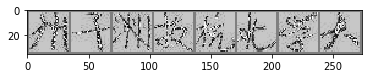

In [45]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

def imshow(img):
    img = img / 2 + 0.5
    nping = img.numpy()
    nping = np.transpose(nping, (1, 2, 0))
    plt.imshow(nping)

dataiter = iter(train_dataloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(labels)

In [46]:
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


In [52]:
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, ic, oc, stride=1):
        super(ResidualBlock, self).__init__()
        # 残差
        self.left = nn.Sequential(
            nn.Conv2d(ic, oc, kernel_size = 3, stride=stride, padding=1),
            nn.BatchNorm2d(oc),
            nn.ReLU(),
            nn.Conv2d(oc, oc, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(oc)
        )
        self.shortcut = nn.Sequential()
        # residual block 经过一次降采样 通道数翻倍
        # 若通道未翻倍，则为普通卷积，不降采样，也不翻倍通道数
        # stride == 1 || ic == oc未降采样
        if stride != 1 or ic != oc:
            self.shortcut = nn.Sequential(
                nn.Conv2d(ic, oc, kernel_size=1, stride=stride),
                nn.BatchNorm2d(oc)
            )

    def forward(self, x):
        out = self.left(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, ResidualBlock, num_classes=10):
        super(ResNet18, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer1 = self.make_layer(ResidualBlock, 64,  2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, channels, num_blocks, stride):
        """
        每个 layer 由多个 residual block 组成
        """
        layers = []
        for i in range(num_blocks):
            if i == 0:
                layers.append(block(self.inchannel, channels, stride))
            else:
                layers.append(block(channels, channels, 1))
            self.inchannel = channels
            
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

net = ResNet18(ResidualBlock)
print(net)

ResNet18(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer1): Sequential(
    (0): ResidualBlock(
      (left): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (left): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 

In [48]:

train_loss_hist = []
test_loss_hist = []

# 验证模型在验证集或者测试集上的准确率
def check_accuracy(loader, model, train):
    if train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')
    num_correct = 0
    num_samples = 0
    model.eval()   # set model to evaluation mode
    with torch.no_grad():
        for x,y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            scores = model(x)
            _,preds = scores.max(1)
            num_correct += (preds==y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 *acc ))
        return acc

def train_model(model, optimizer, epochs=1, scheduler=None):
    '''
    Parameters:
    - model: A Pytorch Module giving the model to train.
    - optimizer: An optimizer object we will use to train the model
    - epochs: A Python integer giving the number of epochs to train
    Returns: best model
    '''
    best_model_wts = None
    best_acc = 0.0
    model = model.to(device=device) # move the model parameters to CPU/GPU
    for e in range(epochs):
        running_loss = 0.0
        num = 0

        if scheduler:
            scheduler.step()
        for t,(x,y) in enumerate(train_dataloader):
            model.train()   # set model to training mode
            x = x.to(device)
            y = y.to(device)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            num += 1
            if(num % 100 == 0 and num != 0):
                with torch.no_grad():
                    for val_data in val_dataloader:
                        val_images, val_labels = val_data
                        val_images = val_images.cuda()
                        val_labels = val_labels.cuda()
                        val_outputs = net(val_images)
                        val_loss = F.cross_entropy(val_outputs, val_labels)
                
                train_loss_hist.append(running_loss / num)
                test_loss_hist.append(val_loss.item())
                running_loss = 0.0
                num = 0

        print('Epoch %d, loss=%.4f' % (e, loss.item()))
        acc = check_accuracy(val_dataloader, model, True)
        if acc > best_acc:
            best_model_wts = copy.deepcopy(model.state_dict())
            best_acc = acc
    print('best_acc:',best_acc)
    model.load_state_dict(best_model_wts)
    return model

In [53]:
from torch.optim import lr_scheduler

optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
best_model = train_model(net, optimizer, epochs=EPOCH_NUM, scheduler=scheduler)

Epoch 0, loss=0.1330
Checking accuracy on validation set
Got 385 / 480 correct (80.21)
Epoch 1, loss=0.4590
Checking accuracy on validation set
Got 455 / 480 correct (94.79)
Epoch 2, loss=0.4824
Checking accuracy on validation set
Got 463 / 480 correct (96.46)
Epoch 3, loss=0.0351
Checking accuracy on validation set
Got 465 / 480 correct (96.88)
Epoch 4, loss=0.0218
Checking accuracy on validation set
Got 461 / 480 correct (96.04)
Epoch 5, loss=0.0357
Checking accuracy on validation set
Got 465 / 480 correct (96.88)
Epoch 6, loss=0.0227
Checking accuracy on validation set
Got 469 / 480 correct (97.71)
Epoch 7, loss=0.0046
Checking accuracy on validation set
Got 466 / 480 correct (97.08)
Epoch 8, loss=0.0016
Checking accuracy on validation set
Got 468 / 480 correct (97.50)
Epoch 9, loss=0.0025
Checking accuracy on validation set
Got 465 / 480 correct (96.88)
Epoch 10, loss=0.0063
Checking accuracy on validation set
Got 471 / 480 correct (98.12)
Epoch 11, loss=0.0009
Checking accuracy on

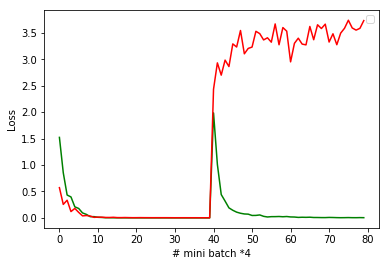

In [54]:
import matplotlib.pyplot as plt

# print(train_loss_hist)
plt.figure()
plt.plot(train_loss_hist, color='green')
plt.plot(test_loss_hist, color='red')
plt.legend('train_loss', 'test_loss')
plt.xlabel('# mini batch *4')
plt.ylabel('Loss')

In [55]:
check_accuracy(test_dataloader, best_model, False)

Checking accuracy on test set
Got 593 / 600 correct (98.83)


0.9883333333333333

In [ ]:
# 0.911 2cnn
# 0.9883333333333333 resnet18